In [1]:
import numpy as np
import pandas as pd
import pickle
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import argparse

from RF.utils_pure import extract_sk_dt

ModuleNotFoundError: No module named 'RF'

In [6]:
def letter2int(letter):
    out = ord(letter) - 65.
    if out > 25:
        out -= 32.
    return out

def chromosome2num(obj):
    if obj == 'X':
        return 23.
    elif obj == 'Y':
        return 24.
    else:
        return float(obj)    

def preprocess_df(df0):
    """preprocessing tumor data
    """
    
    # 결측값 추가
    df0 = df0.fillna(0)
    
    geneNameNum = []
    for letter in df0["geneName"].tolist():
        geneNameNum.append(letter2int(letter[0]))

    chromosomeNum = []
    for letter in df0["chromosome"].tolist():
        chromosomeNum.append(chromosome2num(letter))

    df = df0.copy()
    df["sampleID"]      = le.fit_transform(df["sampleID"]).astype('float')
    df["location"]      = le.fit_transform(df["location"]).astype('float')
    df["geneName"]      = le.fit_transform(df["geneName"]).astype('float')
    ####
    df["geneNameNum"]   = geneNameNum
    df["chromosomeNum"] = chromosomeNum
    df["location"]      = le.fit_transform(df["location"]).astype('float')

    df["mutationType"]  = le.fit_transform(df["mutationType"]).astype('float')
    df["SNP?"]          = le.fit_transform(df["SNP?"]).astype('float')
    df["mutationsEffect_1"] = le.fit_transform(df["mutationsEffect_1"]).astype('float')
    df["mutationsEffect_2"] = le.fit_transform(df["mutationsEffect_2"]).astype('float')
    data_label = np.array(le.fit_transform(df["tumorLOC"]).tolist())

    del df["geneName"]
    del df["chromosome"]
    del df['location']
    
    data = df.copy()
    del data['tumorLOC']
    
    return data, data_label

def train(X_train, Y_train, fn_out="trained_RF.pickle", ntree=21, depth=8, class_weight=None):
    random_forest = RandomForestClassifier(n_estimators=ntree, max_depth = depth, class_weight=class_weight)
    random_forest.fit(X_train, Y_train)
    print("Train accuracy", random_forest.score(X_train, Y_train))
    
    return random_forest

def load_all_files(data_dir):
    filenames = ["Bladder", 
                 "Breast",
                 "Bronchusandlung", 
                 "Cervixuteri", 
                 "Colon",
                 "Corpusuteri", 
                 "Kidney", 
                 "Liverandintrahepaticbileducts", 
                 "Ovary", 
                 "Skin", 
                 "Stomach"]

    variants_ext = "_challenge_variants.txt"

    col_Names = ["sampleID", "geneName", "chromosome", 
                 "location","mutationType","SNP?",
                 "mutationsEffect_1","mutationsEffect_2"]
    
    df0 = pd.DataFrame(columns=col_Names)

    for filename in filenames:
        dataframe = pd.read_csv(data_dir + filename+variants_ext, sep='\t', names = col_Names)
        dataframe['tumorLOC'] = filename
        df0 = pd.concat([df0, dataframe], axis = 0)

    del dataframe
    return df0


In [3]:
if __name__=="__main__":
    parser = argparse.ArgumentParser()
    
    parser.add_argument("data_dir", help="data path")
    parser.add_argument("-n", "--ntree", default=21, help="Number of RF trees")
    parser.add_argument("-d", "--depth", default=8, help="Depth of RF trees")
    
    args = parser.parse_args()

    data_dir = args.data_dir
    ntree = args.ntree
    depth = args.depth
    
    

    le = LabelEncoder()
    sc = StandardScaler()
    np.random.seed(123) # 결과 재현이 가능하도록 시드를 설정합니다.
    

    data_dir = "/home/hoseung/Dropbox/DeepInsight/1. Random Forest Tumor Classification/data/"
    ntree=21
    depth=8
    
    df0 = load_all_files(data_dir)
    
    data, data_label = preprocess_df(df0)
    
    # Standardize
    data = sc.fit_transform(data)
    
    # Split train and valid dataset
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(data, 
                                                                                data_label, 
                                                                                test_size=0.15, 
                                                                                stratify=data_label)

    pickle.dump((X_test, Y_test, le), open("tumor_testset.pickle", "wb"))
    
    # Train RF model
    random_forest = train(X_train, Y_train, fn_out="trained_RF.pickle", ntree=ntree, depth=depth)
    
    # Test accuracy of the original model 
    y_preds = random_forest.predict(X_test)
    print("Test accuracy", accuracy_score(Y_test, y_preds))
    
    # dump tree questions
    RF = [extract_sk_dt(dt) for dt in random_forest]
    pickle.dump(RF, open(fn_out, "wb"))
    
    parser.add_argument("n", "--ntree", help="Number of RF trees")

usage: ipykernel_launcher.py [-h] [-n NTREE] [-d DEPTH] data_dir
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/home/hoseung/anaconda3/envs/deepinsight/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
le = LabelEncoder()
sc = StandardScaler()
np.random.seed(123) # 결과 재현이 가능하도록 시드를 설정합니다.


data_dir = "/home/hoseung/Dropbox/DeepInsight/1. Random Forest Tumor Classification/data/"
ntree=21
depth=8

df0 = load_all_files(data_dir)

data, data_label = preprocess_df(df0)

# Standardize
data = sc.fit_transform(data)

# Split train and valid dataset
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(data, 
                                                                            data_label, 
                                                                            test_size=0.15, 
                                                                            stratify=data_label)

pickle.dump((X_test, Y_test, le), open("tumor_testset.pickle", "wb"))

In [8]:
# Train RF model
for cw in ['balanced', 'balanced_subsample', None]:
    random_forest = train(X_train, Y_train,
                          fn_out="trained_RF.pickle",
                          ntree=ntree,
                          depth=depth, 
                          class_weight=cw)

    # Test accuracy of the original model 
    y_preds = random_forest.predict(X_test)
    print(cw,  "Test accuracy", accuracy_score(Y_test, y_preds))

# dump tree questions
#RF = [extract_sk_dt(dt) for dt in random_forest]
#pickle.dump(RF, open(fn_out, "wb"))

Train accuracy 0.5347014809418086
balanced Test accuracy 0.5335953040926137
Train accuracy 0.586469990412493
balanced_subsample Test accuracy 0.5862481656611772
Train accuracy 0.581108813025198
None Test accuracy 0.5799347790640795


In [9]:
dt = random_forest.estimators_[0]

In [14]:
dt.tree_.value.squeeze(1).shape

(465, 11)

In [19]:
leaf = np.where(dt.tree_.feature >= 0)[0]

In [21]:
len(leaf)

232

In [15]:
import matplotlib.pyplot as plt 

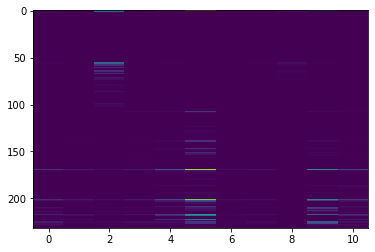

In [24]:
fig, ax = plt.subplots()
ax.imshow(dt.tree_.value[leaf].squeeze(1), interpolation='none')
ax.set_aspect("auto")
plt.show()

RF 결과를 낼 때 value 값 node당으로 Normalize된 뒤에 곱해지는데,  
전체 class = 5인 샘플 중 얼마다 node x에 들어갔는지 비율을 봐야하는게 아닐까? 